In [25]:
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'notebooks'))
	print(os.getcwd())
except:
	pass

 # VIS Tutorial

 When starting an image-based phenotyping project it is important to consider what the end goals of the project are.
 This is important because the goals of the project will determine the the camera type, imaging layout, and will help to
 guide downstream analysis. For example, if the goal of the project is to quantify the growth rates of a population of
 Arabidopsis plants, you may want to take timelapse images of whole flats of plants with an RGB (VIS) camera.

 To run a VIS workflow over a single VIS image there are two required inputs:

 1.  **Image:** Images can be processed regardless of what type of VIS camera was used (high-throughput platform, digital camera, cell phone camera).
 Image processing will work with adjustments if images are well lit and free of background that is similar in color to plant material.
 2.  **Output directory:** If debug mode is set to 'print' output images from each step are produced.

In [26]:
# Import PlantCV 
from plantcv import plantcv as pcv
import matplotlib
import cv2



In [27]:
class options:
    def __init__(self):
        self.image = "img/tutorial_images/vis/original_image.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "./vis_tutorial_results"
        self.outdir = "."
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug



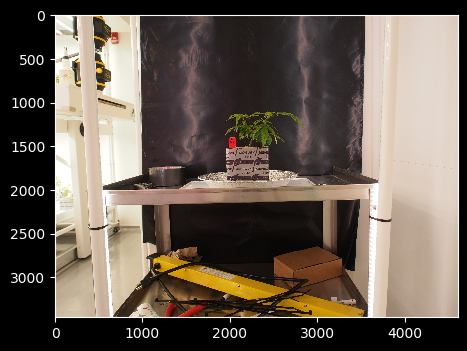

In [28]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)


In [29]:
#Crop image
img = img[0:1500,1500:3000].copy()
#cv2.imshow("cropped",crop_img)
#cv2.waitKey(0)
img


array([[[ 53,  50,  59],
        [ 53,  50,  59],
        [ 53,  49,  60],
        ...,
        [ 44,  42,  48],
        [ 44,  43,  47],
        [ 44,  43,  47]],

       [[ 55,  52,  61],
        [ 54,  51,  60],
        [ 54,  51,  60],
        ...,
        [ 44,  42,  48],
        [ 43,  42,  46],
        [ 43,  42,  46]],

       [[ 56,  53,  62],
        [ 53,  50,  59],
        [ 53,  50,  59],
        ...,
        [ 43,  41,  47],
        [ 43,  41,  47],
        [ 43,  41,  47]],

       ...,

       [[106, 111, 136],
        [103, 108, 133],
        [100, 104, 128],
        ...,
        [ 60,  59,  68],
        [ 60,  59,  68],
        [ 59,  58,  67]],

       [[104, 108, 132],
        [102, 106, 130],
        [101, 104, 125],
        ...,
        [ 60,  59,  68],
        [ 59,  58,  67],
        [ 59,  58,  67]],

       [[101, 105, 129],
        [103, 105, 129],
        [100, 103, 124],
        ...,
        [ 59,  58,  67],
        [ 59,  58,  67],
        [ 59,  58,  67]]

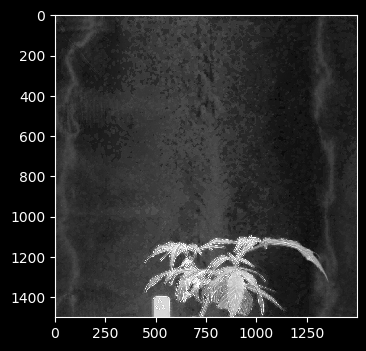

In [30]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_image - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')



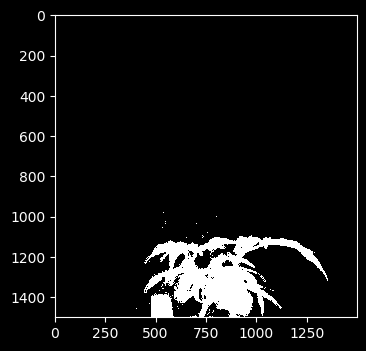

In [31]:
# Threshold can be on either light or dark objects in the image. 

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the background then standard threshold is done.
#                 If the object is darker than the background then inverse thresholding is done. 
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')



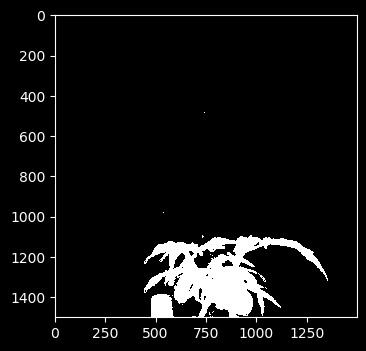

In [32]:
# Median Blur 

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)



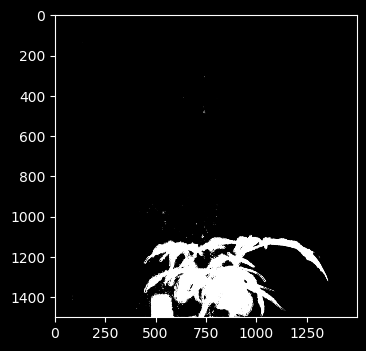

In [33]:
# An alternative to using median_blur is gaussian_blur, which applies 
# a gaussian blur filter to the image. Depending on the image, one 
# technique may be more effective than others. 

# Inputs:
#   img - RGB or grayscale image data
#   ksize - Tuple of kernel size
#   sigma_x - Standard deviation in X direction; if 0 (default), 
#            calculated from kernel size
#   sigma_y - Standard deviation in Y direction; if sigmaY is 
#            None (default), sigmaY is taken to equal sigmaX
gaussian_img = pcv.gaussian_blur(img=s_thresh, ksize=(5, 5), sigma_x=0, sigma_y=None)



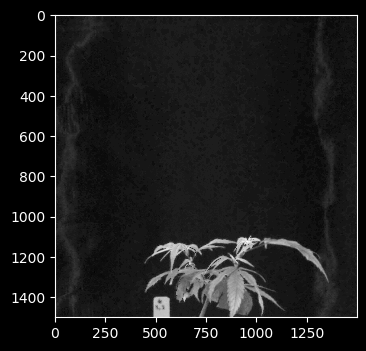

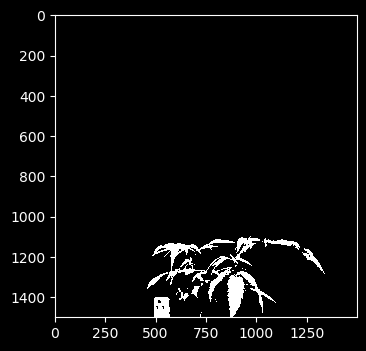

In [34]:
# Convert RGB to LAB and extract the blue channel ('b')

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue channel image 

b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, 
                                object_type='light')



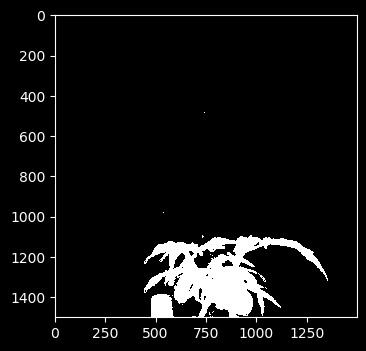

In [35]:
# Join the threshold saturation and blue-yellow images

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_thresh)



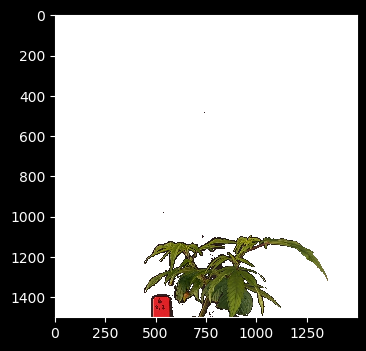

In [36]:
# Appy Mask (for VIS images, mask_color='white')

# Inputs:
#   rgb_img - RGB image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(rgb_img=img, mask=bs, mask_color='white')


 Now we'll focus on capturing the plant in the masked image. We will use masked green-magenta and blue-yellow channels.
 Then two channels are thresholded to caputre different portions of the plant, and thre three images are joined together.
 Small objected are filled, and the resulting binary image is used to mask the masked image previously obtained.

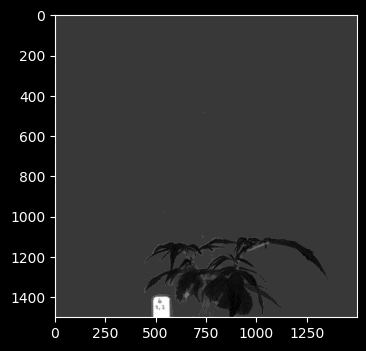

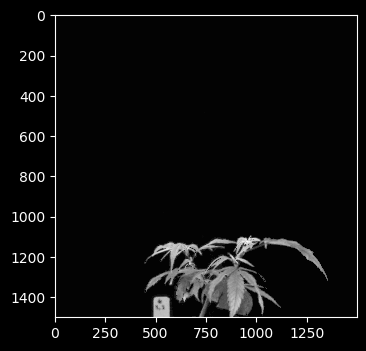

In [37]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels

masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')



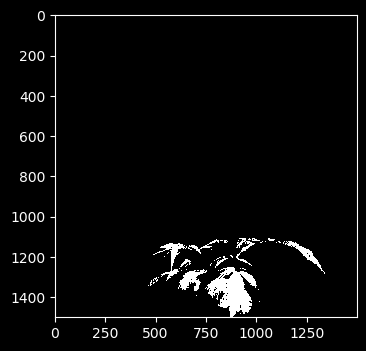

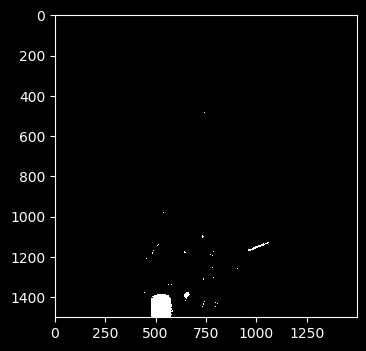

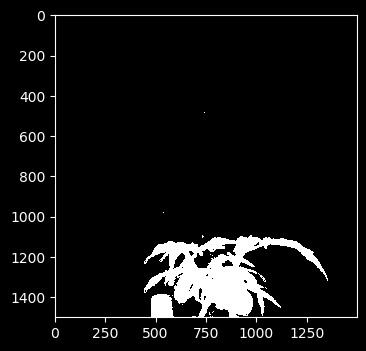

In [38]:
# Threshold the green-magenta and blue images

maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                      max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                       max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                      max_value=255, object_type='light')



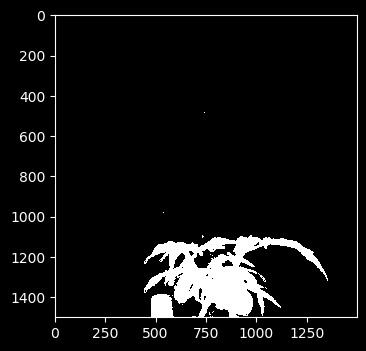

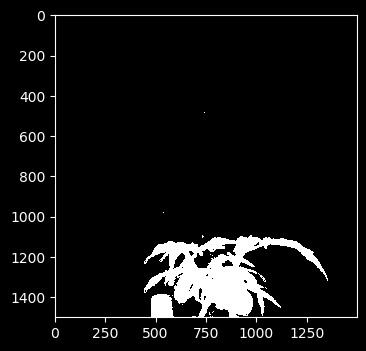

In [39]:
# Join the thresholded saturation and blue-yellow images (OR)

ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)



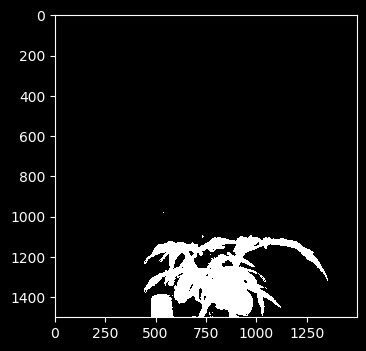

In [40]:
# Filters out bright noise from an image.

# Inputs:
#   gray_img - Grayscale or binary image data
#   kernel - Optional neighborhood, expressed as an array of 1's and 0's. If None (default),
#   uses cross-shaped structuring element.
opened_ab = pcv.opening(gray_img=ab)



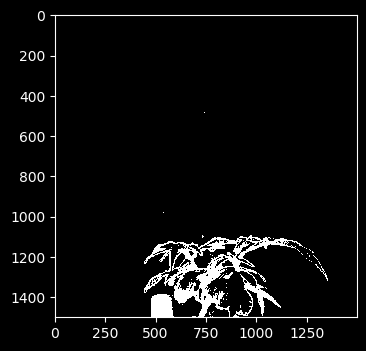

In [41]:
# Depending on the situation it might be useful to use the 
# exclusive or (pcv.logical_xor) function. 

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
xor_img = pcv.logical_xor(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)



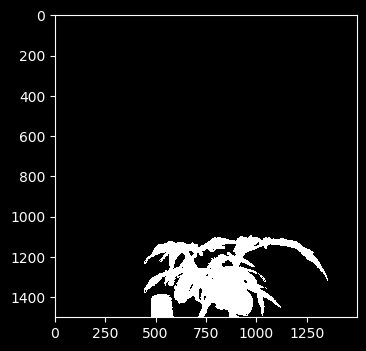

In [42]:
# Fill small objects (reduce image noise) 

# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
ab_fill = pcv.fill(bin_img=ab, size=200)



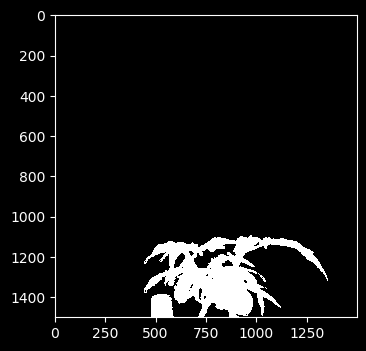

In [43]:
# Filters out dark noise from an image.

# Inputs:
#   gray_img - Grayscale or binary image data
#   kernel - Optional neighborhood, expressed as an array of 1's and 0's. If None (default),
#   uses cross-shaped structuring element.
closed_ab = pcv.closing(gray_img=ab_fill)



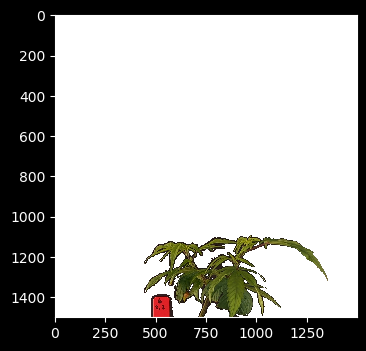

In [44]:
# Apply mask (for VIS images, mask_color=white)

masked2 = pcv.apply_mask(rgb_img=masked, mask=ab_fill, mask_color='white')


 Now we need to identify the objects (also called contours) within the image

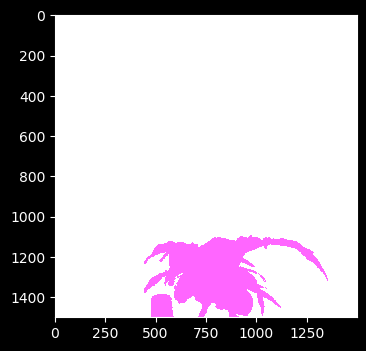

In [45]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)



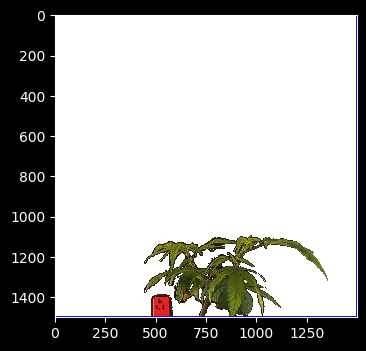

In [46]:
# Define the region of interest (ROI) 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=0, y=0, h=1500, w=1500)



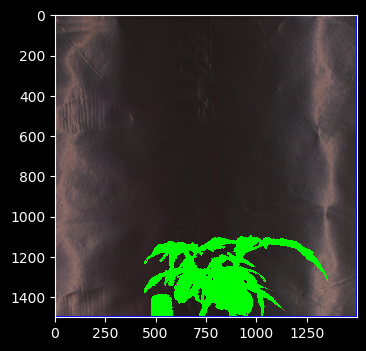

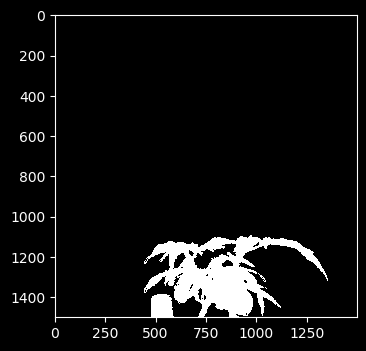

In [47]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside), 'cutto', or 
#    'largest' (keep only largest contour)
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')



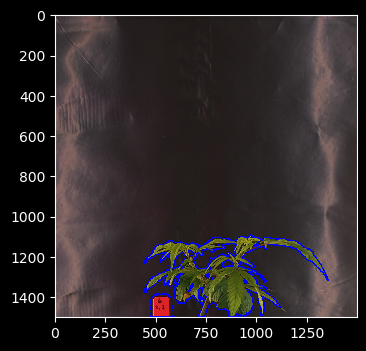

In [48]:
# Object combine kept objects

# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)


 The next step is to analyze the plant object for traits such as horizontal height, shape, or color.

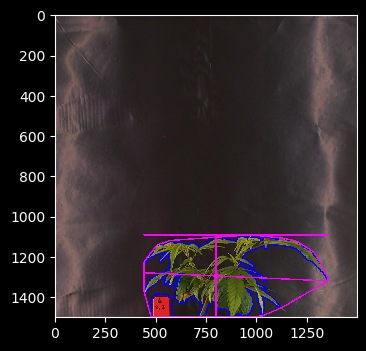

In [49]:
############### Analysis ################ 
  
# Find shape properties, output shape image (optional)

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 

analysis_image = pcv.analyze_object(img=img, obj=obj, mask=mask)



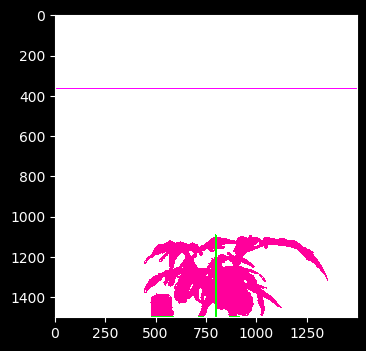

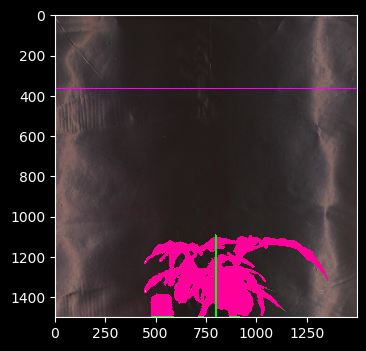

In [50]:
# Shape properties relative to user boundary line (optional)

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the bottom of the image) 
boundary_image2 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, 
                                               line_position=370)



C:\Users\Fin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\plotnine-0.5.1-py3.7.egg\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\Fin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\plotnine-0.5.1-py3.7.egg\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
<ggplot: (20667417)>


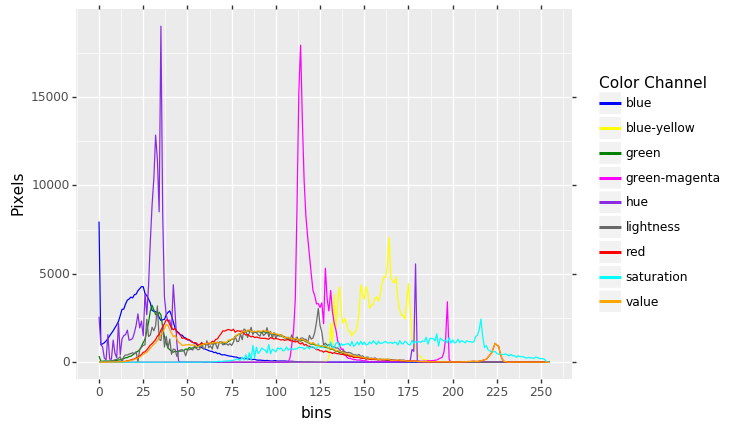

In [51]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
#                    This is the data to be printed to the SVG histogram file  
color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all')



In [52]:
# Print the histogram out 
pcv.print_image(img=color_histogram, filename="vis_tutorial_color_hist.jpg")



C:\Users\Fin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\plotnine-0.5.1-py3.7.egg\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Fin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\plotnine-0.5.1-py3.7.egg\plotnine\ggplot.py:707: UserWarning: Filename: vis_tutorial_color_hist.jpg
  warn('Filename: {}'.format(filename))
C:\Users\Fin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\plotnine-0.5.1-py3.7.egg\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\Fin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\plotnine-0.5.1-py3.7.egg\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable inst

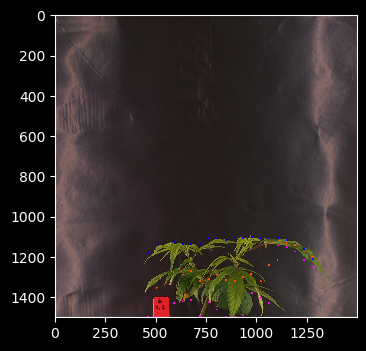

In [53]:
# Divide plant object into twenty equidistant bins and assign pseudolandmark points based upon their 
# actual (not scaled) position. Once this data is scaled this approach may provide some information 
# regarding shape independent of size.

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
top_x, bottom_x, center_v_x = pcv.x_axis_pseudolandmarks(img=img, obj=obj, mask=mask)



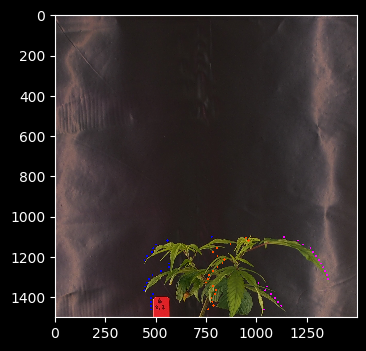

In [54]:
top_y, bottom_y, center_v_y = pcv.y_axis_pseudolandmarks(img=img, obj=obj, mask=mask)



In [55]:
# The print_results function will take the measurements stored when running any (or all) of these functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.print_results(filename='vis_tutorial_results.txt')


